# L2 – Multilayer perceptron

### PyTorch
1. [Installing PyTorch](https://pytorch.org/get-started/locally/)
2. [What is PyTorch?](https://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html#sphx-glr-beginner-blitz-tensor-tutorial-py)
3. [Autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html#sphx-glr-beginner-blitz-autograd-tutorial-py)
4. [Useful examples](https://pytorch.org/tutorials/beginner/pytorch_with_examples.html)
5. [Mnist example](https://habr.com/company/otus/blog/358096/)


### One more thing
1. [Jupyter tutorial](https://habrahabr.ru/company/wunderfund/blog/316826/)
2. [Plot.ly](https://plot.ly/python/)
3. [Widgets](http://jupyter.org/widgets.html)

### 1. Linear multi-classification problem

We have already learned binary linear classifier
$$y = \text{sign}(w^Tx).$$
There are [several approaches](https://en.wikipedia.org/wiki/Multiclass_classification) to solve the problem of multi-class classification. For example [reduction](https://en.wikipedia.org/wiki/Multiclass_classification#Transformation_to_Binary) of problem to binary classifier or [modification](https://en.wikipedia.org/wiki/Support_vector_machine#Multiclass_SVM) of the known model. However we are interested in approaches that is applied in neural networks.

For each class $c \in 1, \dots, |C|$ we have an individual row $w_i$ of matrix $W$. Then the probability of $x$ belonging to a particular class is equal to
$$p_i = \frac{\exp(w^T_ix)}{\sum_j \exp(w^T_jx)}.$$
This is nothing, but [softmax](https://en.wikipedia.org/wiki/Softmax_function) function of $Wx$.
$$(p_1, \dots, p_{|C|}) = \text{softmax}(Wx).$$

If you look closely, $\text{softmax}$ is a more general variant of sigmoid. To see this, it suffices to consider the case $|C|=2$. As usual the training can be reduced to minimization of the empirical risk, namely, optimization problem
$$\arg\min_W Q(W) = \arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)).$$
Actually, the maximization of the log-likelihood is written above.

#### Exercises
1. Find $\frac{dQ}{dW}$ in matrix form (hint: start with $\frac{dQ}{dw_i}$ for begining).
2. Please plot several mnist images (e.g using grid 5x5).
3. Train linear multi-label classifier for [mnist](https://www.kaggle.com/c/digit-recognizer) dataset (possible, [this tutorial](https://habr.com/company/otus/blog/358096/) can help you).
4. Chek accuracy on train and validation sets (visualize resulted graph).

In [1]:
import utils
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [55]:
import pandas as pd
import torchvision.datasets
import torchvision.transforms as transforms
batch_size = 10
all_train = torchvision.datasets.MNIST("/home/aliia/Simagin/mnist", train=True, transform=transforms.ToTensor(), download=True)
test = torchvision.datasets.MNIST("/home/aliia/Simagin/mnist", train=False, transform=transforms.ToTensor(), download=True)
train_loader = torch.utils.data.DataLoader(all_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)
print(type(all_train))

<class 'torchvision.datasets.mnist.MNIST'>


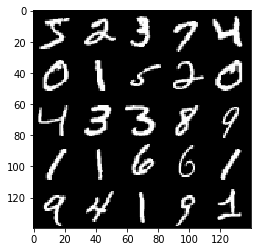

In [69]:
import matplotlib.pyplot as plt
import numpy as np
count = 0
ans = np.zeros((28*5, 0))
ans_i = np.zeros((0, 28))
for (x, y) in all_train:
    if (count == 25):
        break;
    c = x[0].view((28, 28)).numpy()
    ans_i = np.concatenate((ans_i, c), axis=0)
    if (count % 5 == 4):
        ans = np.concatenate((ans, ans_i), axis=1)
        ans_i = np.zeros((0, 28))
    count += 1
plt.imshow(ans, cmap="gray")
plt.show()

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 10) # params - 2D-Tensor 28*28x100
        
    def forward(self, x):
        # x.shape = [50, 1, 28, 28] => [50, 784] => [50, 100] => [50, 10]
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

In [5]:
model = Net()
optimizer = optim.SGD(model.parameters(), lr=0.01)
accuracy_data_train = []
accuracy_data_test = []

In [77]:
def train(epoch):
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 200 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.data.item()))
#         else:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                 100. * batch_idx / len(train_loader), loss.data.item()))

In [78]:
def test():
    with torch.no_grad():
        test_loss = 0
        test_correct = 0
        for data, target in test_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            test_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            test_correct += pred.eq(target.data.view_as(pred)).sum()
        test_loss /= len(test_loader.dataset)
        test_correct_percent = 100. * test_correct / len(test_loader.dataset)

        train_loss = 0
        train_correct = 0
        for data, target in train_loader:
            data, target = Variable(data), Variable(target)
            output = model(data)
            train_loss += F.cross_entropy(output, target, size_average=False).data.item() # sum up batch loss
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            train_correct += pred.eq(target.data.view_as(pred)).sum()
        train_loss /= len(train_loader.dataset)
        train_correct_percent = 100. * train_correct / len(train_loader.dataset)
    accuracy_data_train.append(train_correct_percent)
    accuracy_data_test.append(test_correct_percent) 
    print('\nTest set:  Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, test_correct, len(test_loader.dataset), test_correct_percent))
    print('Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        train_loss, train_correct, len(train_loader.dataset), train_correct_percent))

In [79]:
epoch_size = 20
for epoch in range(1, epoch_size):
    train(epoch)
    test()

/home/aliia/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 1.859615
Train Epoch: 1 [2000/60000 (3%)]	Loss: 1.760345
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.763998
Train Epoch: 1 [6000/60000 (10%)]	Loss: 1.677660
Train Epoch: 1 [8000/60000 (13%)]	Loss: 1.779584
Train Epoch: 1 [10000/60000 (17%)]	Loss: 1.759333
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.698698
Train Epoch: 1 [14000/60000 (23%)]	Loss: 1.666377
Train Epoch: 1 [16000/60000 (27%)]	Loss: 1.802704
Train Epoch: 1 [18000/60000 (30%)]	Loss: 1.870584
Train Epoch: 1 [20000/60000 (33%)]	Loss: 1.857665
Train Epoch: 1 [22000/60000 (37%)]	Loss: 1.661194
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.872249
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.761881
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.673057
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.756734
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.760390
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.850007
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.565776
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.662223
Train Epoch

/home/aliia/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set:  Average loss: 1.7094, Accuracy: 7558/10000 (75%)
Train set: Average loss: 1.7074, Accuracy: 45493/60000 (75%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.748571
Train Epoch: 2 [2000/60000 (3%)]	Loss: 1.884719
Train Epoch: 2 [4000/60000 (7%)]	Loss: 1.563874
Train Epoch: 2 [6000/60000 (10%)]	Loss: 1.610771
Train Epoch: 2 [8000/60000 (13%)]	Loss: 1.662941
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.665778
Train Epoch: 2 [12000/60000 (20%)]	Loss: 1.855273
Train Epoch: 2 [14000/60000 (23%)]	Loss: 1.758325
Train Epoch: 2 [16000/60000 (27%)]	Loss: 1.758946
Train Epoch: 2 [18000/60000 (30%)]	Loss: 1.561991
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.560586
Train Epoch: 2 [22000/60000 (37%)]	Loss: 1.684579
Train Epoch: 2 [24000/60000 (40%)]	Loss: 1.663322
Train Epoch: 2 [26000/60000 (43%)]	Loss: 1.659215
Train Epoch: 2 [28000/60000 (47%)]	Loss: 1.595315
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.649352
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.560407
Train Epoch: 2 [34000/60000 (57%)]	Los

Train Epoch: 7 [2000/60000 (3%)]	Loss: 1.575739
Train Epoch: 7 [4000/60000 (7%)]	Loss: 1.655222
Train Epoch: 7 [6000/60000 (10%)]	Loss: 1.825802
Train Epoch: 7 [8000/60000 (13%)]	Loss: 1.856226
Train Epoch: 7 [10000/60000 (17%)]	Loss: 1.626436
Train Epoch: 7 [12000/60000 (20%)]	Loss: 1.661842
Train Epoch: 7 [14000/60000 (23%)]	Loss: 1.865436
Train Epoch: 7 [16000/60000 (27%)]	Loss: 1.461356
Train Epoch: 7 [18000/60000 (30%)]	Loss: 1.575825
Train Epoch: 7 [20000/60000 (33%)]	Loss: 1.901854
Train Epoch: 7 [22000/60000 (37%)]	Loss: 1.770809
Train Epoch: 7 [24000/60000 (40%)]	Loss: 1.565191
Train Epoch: 7 [26000/60000 (43%)]	Loss: 1.757436
Train Epoch: 7 [28000/60000 (47%)]	Loss: 1.858342
Train Epoch: 7 [30000/60000 (50%)]	Loss: 1.744477
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.965911
Train Epoch: 7 [34000/60000 (57%)]	Loss: 1.802604
Train Epoch: 7 [36000/60000 (60%)]	Loss: 1.756062
Train Epoch: 7 [38000/60000 (63%)]	Loss: 1.711680
Train Epoch: 7 [40000/60000 (67%)]	Loss: 1.747766
Train 

Train Epoch: 12 [6000/60000 (10%)]	Loss: 1.860884
Train Epoch: 12 [8000/60000 (13%)]	Loss: 1.664729
Train Epoch: 12 [10000/60000 (17%)]	Loss: 1.756088
Train Epoch: 12 [12000/60000 (20%)]	Loss: 1.562090
Train Epoch: 12 [14000/60000 (23%)]	Loss: 1.462892
Train Epoch: 12 [16000/60000 (27%)]	Loss: 1.766041
Train Epoch: 12 [18000/60000 (30%)]	Loss: 1.890715
Train Epoch: 12 [20000/60000 (33%)]	Loss: 1.568235
Train Epoch: 12 [22000/60000 (37%)]	Loss: 1.463352
Train Epoch: 12 [24000/60000 (40%)]	Loss: 1.761249
Train Epoch: 12 [26000/60000 (43%)]	Loss: 1.854890
Train Epoch: 12 [28000/60000 (47%)]	Loss: 1.461604
Train Epoch: 12 [30000/60000 (50%)]	Loss: 1.676043
Train Epoch: 12 [32000/60000 (53%)]	Loss: 1.619161
Train Epoch: 12 [34000/60000 (57%)]	Loss: 1.463911
Train Epoch: 12 [36000/60000 (60%)]	Loss: 1.605617
Train Epoch: 12 [38000/60000 (63%)]	Loss: 1.667027
Train Epoch: 12 [40000/60000 (67%)]	Loss: 1.561889
Train Epoch: 12 [42000/60000 (70%)]	Loss: 1.569164
Train Epoch: 12 [44000/60000 (73%

Train Epoch: 17 [6000/60000 (10%)]	Loss: 1.664078
Train Epoch: 17 [8000/60000 (13%)]	Loss: 1.570715
Train Epoch: 17 [10000/60000 (17%)]	Loss: 1.850029
Train Epoch: 17 [12000/60000 (20%)]	Loss: 1.815650
Train Epoch: 17 [14000/60000 (23%)]	Loss: 1.658596
Train Epoch: 17 [16000/60000 (27%)]	Loss: 1.669557
Train Epoch: 17 [18000/60000 (30%)]	Loss: 1.562175
Train Epoch: 17 [20000/60000 (33%)]	Loss: 1.677558
Train Epoch: 17 [22000/60000 (37%)]	Loss: 1.514749
Train Epoch: 17 [24000/60000 (40%)]	Loss: 1.660982
Train Epoch: 17 [26000/60000 (43%)]	Loss: 1.925570
Train Epoch: 17 [28000/60000 (47%)]	Loss: 1.736209
Train Epoch: 17 [30000/60000 (50%)]	Loss: 1.931199
Train Epoch: 17 [32000/60000 (53%)]	Loss: 1.700363
Train Epoch: 17 [34000/60000 (57%)]	Loss: 1.853011
Train Epoch: 17 [36000/60000 (60%)]	Loss: 1.482948
Train Epoch: 17 [38000/60000 (63%)]	Loss: 1.557761
Train Epoch: 17 [40000/60000 (67%)]	Loss: 1.722341
Train Epoch: 17 [42000/60000 (70%)]	Loss: 1.662555
Train Epoch: 17 [44000/60000 (73%

[tensor(80), tensor(87), tensor(88), tensor(89), tensor(89), tensor(89), tensor(89), tensor(90), tensor(90), tensor(90), tensor(90), tensor(90), tensor(90), tensor(90), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91)]
[tensor(81), tensor(88), tensor(89), tensor(89), tensor(90), tensor(90), tensor(90), tensor(90), tensor(90), tensor(90), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91), tensor(91)]
accuracy on train set:


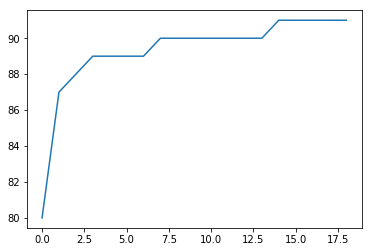

accuracy on test set:


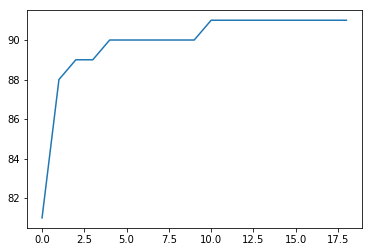

In [15]:
import matplotlib
print(accuracy_data_train)
print(accuracy_data_test)
print("accuracy on train set:")
plt.plot(range(epoch_size - 1), accuracy_data_train)
plt.show()
print("accuracy on test set:")
plt.plot(range(epoch_size - 1), accuracy_data_test)
plt.show()

Let's briefly touch on themes of regularization. As was discussed before, there are different approaches. We focus on the modification of loss function.

$$\arg\min_W -\frac{1}{\mathcal{l}}\sum_y\sum_i [y = i] \cdot \ln(p_i(W)) + \lambda_1 L_1(W) + \lambda_2 L_2(W)$$

1. $L_1(W) = sum_{i,j} |w_{i,j}|$ - sparsify weights (force to not use uncorrelated features)
2. $L_2(W) = sum_{i,j} w_{i,j}^2$ - minimize weights (force to not overfit)

#### Exercises
1. Train model again using both type of regularization.
2. Plot matrix of weights.
3. Which pixels have zero weights? What does it mean?
4. Have you improved accuracy on validation?

### 2. Universal approximation theorem

What if we add more layers to our model? Namely, we train two matrix $W_2$ and $W_1$
$$softmax(W_2\cdot(W_1x)).$$

At first glance adding more parameters helps to increase the generalizing ability of the model. Buy actually we have the same model $softmax(Wx)$, where $W = W_2\cdot W_1$. But everyting changes with adding ome more layer. Let's add nonlinear function $\sigma$ between $W_2$ and $W_1$

$$softmax(W_2\cdot \sigma(W_1x)).$$

Kurt Hornik showed in 1991 that it is not the specific choice of the nonlinear function, but rather the multilayer feedforward architecture itself which gives neural networks the potential of being universal approximators. The output units are always assumed to be linear. For notational convenience, only the single output case will be shown. The general case can easily be deduced from the single output case.

Let $\sigma(\cdot)$ be a nonconstant, bounded, and monotonically-increasing continuous function.
Let $\mathcal{S}_m \subset \mathbb{R}^m$ denote any compact set. 
Then, given any $\varepsilon > 0$ and any coninuous function $f$ on $\mathcal{S}_m$, there exist an integer $N$ and real constants $v_i$, $b_i$ amd real vectors $w_i$ that

$$\left| \sum _{i=1}^{N}v_{i}\sigma \left( w_i^{T} x+b_i \right) - f(x) \right| < \varepsilon, ~~~ \forall x \in \mathcal{S}_m.$$

The theorem has non-constructive proof, it meams that no estimates for $N$ and no method to find approximation's parameters.

#### Exercises
1. Let $\sigma$ – [heaviside step function](https://en.wikipedia.org/wiki/Heaviside_step_function) and $x \in \{0, 1\}^2$. Prove that $y = \sigma(wx + b)$ can approximate boolean function **OR** (hint: use constructive proof).
2. What about **AND** function?
3. Is it possible to implement **XOR**? Prove your words.
4. Prove that 2-layer network can implement any boolean function.

#### More useful facts:
1. A 2-layer network in in $\mathbb{R}^n$ allows to define convex polyhedron..
2. A 3-layer network in в $\mathbb{R}^n$ allows to define a not necessarily convex and not even necessarily connected area.

### 3. Backpropagation
Backpropagation is a method used to calculate the error contribution of each layer after a batch of data. It is a special case of an older and more general technique called automatic differentiation. In the context of learning, backpropagation is commonly used by the gradient descent optimization algorithm to adjust the weight of layers by calculating the gradient of the loss function. This technique is also sometimes called backward propagation of errors, because the error is calculated at the output and distributed back through the network layers. The main motivation of method is simplify evaluation of gradient which is complex problem for multilayer nets.

We need the following notation. Let $(y^1,\dots,y^n) = f(x^1,\dots,x^n)$ is some differentiable function and $\frac{dy}{dx}$ is matrix
$$\frac{dy}{dx} = \Big[ J_{ij} = \frac{\partial y^i}{\partial x^j} \Big]$$

Without violating the generality, we can assume that each layer is a function $x_{i} = f(x_{i-1}, w_i)$. As last layer we add loss function, so we can assume our multi-layer net as function $Q(x_0) = Q(f_n(f_{n-1}(\dots, w_{n-1}), w_n))$.

#### Forward step
Propagation forward through the network to generate the output values. Calculation of the loss function.

#### Backward step
Let's look at last layer. We can simply find $\frac{dQ}{dx_n}$. Now we can evaluate 

$$\frac{dQ}{dw_n} = \frac{dQ}{dx_n}\frac{dx_n}{dw_n} \text{ and } \frac{dQ}{dx_{n-1}} = \frac{dQ}{dx_n}\frac{dx_n}{dx_{n-1}}$$

Now we need calculate $\frac{dQ}{dw_{n-2}}$ и $\frac{dQ}{dx_{n-2}}$. But we have the same situation. We know $\frac{dQ}{dx_k}$, so can evaluate $\frac{dQ}{dw_k}$ and $\frac{dQ}{dx_{k-1}}$. Repeating this operation we find all the gradients. Now it's only remains to make a gradient step to update weights.

#### Exercises
1. Read more about [vanishing gradient](https://en.wikipedia.org/wiki/Vanishing_gradient_problem).
2. Train 2 layer net. Use sigmoid as nonlinearity.
3. Check accuracy on validation set.
4. Use [ReLu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks) or LeakyReLu as nonlinearity. Compare accuracy and convergence with previous model.
5. Play with different architectures (add more layers, regularization and etc).
6. Show your best model.
7. How does quality change with adding layers. Prove your words, train model for 2, 3, 5, 7 and 10 layers.
8. Using backpropagation find optimal  digit 8 for your net.*

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 100) # params - 2D-Tensor 28*28x100
        self.fc2 = nn.Linear(100, 10) # params - 2D-Tensor 28*28x100

    def forward(self, x):
        # x.shape = [50, 1, 28, 28] => [50, 784] => [50, 100] => [50, 10]
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [ ]:
model = Net()

In [1]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
accuracy_data_train = []
accuracy_data_test = []
epoch_size = 10
for epoch in range(1, epoch_size):
    train(epoch)
    test(err_log)

NameError: name 'optim' is not defined

In [25]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 300) # params - 2D-Tensor 28*28x100
        self.fc2 = nn.Linear(300, 10) # params - 2D-Tensor 28*28x100

    def forward(self, x):
        # x.shape = [50, 1, 28, 28] => [50, 784] => [50, 100] => [50, 10]
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x

In [26]:
model = Net()

In [27]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
accuracy_data_train = []
accuracy_data_test = []
epoch_size = 10
for epoch in range(1, epoch_size):
    train(epoch)
    test(err_log)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.297894
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.298994
Train Epoch: 1 [4000/60000 (7%)]	Loss: 2.291040
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.285673
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.265836
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.248547
Train Epoch: 1 [12000/60000 (20%)]	Loss: 2.248454
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.248942
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.228522
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.106498
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.005607
Train Epoch: 1 [22000/60000 (37%)]	Loss: 2.136587
Train Epoch: 1 [24000/60000 (40%)]	Loss: 2.103742
Train Epoch: 1 [26000/60000 (43%)]	Loss: 1.838754
Train Epoch: 1 [28000/60000 (47%)]	Loss: 1.953007
Train Epoch: 1 [30000/60000 (50%)]	Loss: 1.741940
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.755755
Train Epoch: 1 [34000/60000 (57%)]	Loss: 1.784132
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.712964
Train Epoch: 1 [38000/60000 (63%)]	Loss: 1.855812
Train Epoch

/home/aliia/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set:  Average loss: 1.6893, Accuracy: 8227/10000 (82%)
Train set: Average loss: 1.6971, Accuracy: 48850/60000 (81%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.684735
Train Epoch: 2 [2000/60000 (3%)]	Loss: 1.619574
Train Epoch: 2 [4000/60000 (7%)]	Loss: 1.591195
Train Epoch: 2 [6000/60000 (10%)]	Loss: 1.477520
Train Epoch: 2 [8000/60000 (13%)]	Loss: 1.635632
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.660017
Train Epoch: 2 [12000/60000 (20%)]	Loss: 1.682751
Train Epoch: 2 [14000/60000 (23%)]	Loss: 1.915801
Train Epoch: 2 [16000/60000 (27%)]	Loss: 1.612552
Train Epoch: 2 [18000/60000 (30%)]	Loss: 1.754623
Train Epoch: 2 [20000/60000 (33%)]	Loss: 1.681666
Train Epoch: 2 [22000/60000 (37%)]	Loss: 1.639141
Train Epoch: 2 [24000/60000 (40%)]	Loss: 1.539930
Train Epoch: 2 [26000/60000 (43%)]	Loss: 1.628346
Train Epoch: 2 [28000/60000 (47%)]	Loss: 1.759138
Train Epoch: 2 [30000/60000 (50%)]	Loss: 1.707213
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.707332
Train Epoch: 2 [34000/60000 (57%)]	Los

Train Epoch: 7 [2000/60000 (3%)]	Loss: 1.551746
Train Epoch: 7 [4000/60000 (7%)]	Loss: 1.682453
Train Epoch: 7 [6000/60000 (10%)]	Loss: 1.478631
Train Epoch: 7 [8000/60000 (13%)]	Loss: 1.556072
Train Epoch: 7 [10000/60000 (17%)]	Loss: 1.604690
Train Epoch: 7 [12000/60000 (20%)]	Loss: 1.667416
Train Epoch: 7 [14000/60000 (23%)]	Loss: 1.481554
Train Epoch: 7 [16000/60000 (27%)]	Loss: 1.550333
Train Epoch: 7 [18000/60000 (30%)]	Loss: 1.645603
Train Epoch: 7 [20000/60000 (33%)]	Loss: 1.565243
Train Epoch: 7 [22000/60000 (37%)]	Loss: 1.468141
Train Epoch: 7 [24000/60000 (40%)]	Loss: 1.495048
Train Epoch: 7 [26000/60000 (43%)]	Loss: 1.564198
Train Epoch: 7 [28000/60000 (47%)]	Loss: 1.665474
Train Epoch: 7 [30000/60000 (50%)]	Loss: 1.561937
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.623895
Train Epoch: 7 [34000/60000 (57%)]	Loss: 1.577236
Train Epoch: 7 [36000/60000 (60%)]	Loss: 1.473918
Train Epoch: 7 [38000/60000 (63%)]	Loss: 1.555698
Train Epoch: 7 [40000/60000 (67%)]	Loss: 1.494186
Train 

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(784, 500)
        self.fc2 = nn.Linear(500, 100)
        self.fc3 = nn.Linear(100, 10)
    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = F.sigmoid(x)
        x = self.fc2(x)
        x = F.sigmoid(x)
        x = self.fc3(x)
        x = F.softmax(x, dim=1)
        return x

In [36]:
model = Net()

In [38]:
optimizer = optim.SGD(model.parameters(), lr=0.01)
accuracy_data_train = []
accuracy_data_test = []
epoch_size = 10
for epoch in range(1, epoch_size):
    train(epoch)
    test(err_log)

/home/aliia/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.091350
Train Epoch: 1 [2000/60000 (3%)]	Loss: 2.168348
Train Epoch: 1 [4000/60000 (7%)]	Loss: 1.975511
Train Epoch: 1 [6000/60000 (10%)]	Loss: 2.122536
Train Epoch: 1 [8000/60000 (13%)]	Loss: 2.007885
Train Epoch: 1 [10000/60000 (17%)]	Loss: 2.085927
Train Epoch: 1 [12000/60000 (20%)]	Loss: 1.990933
Train Epoch: 1 [14000/60000 (23%)]	Loss: 2.032106
Train Epoch: 1 [16000/60000 (27%)]	Loss: 2.152297
Train Epoch: 1 [18000/60000 (30%)]	Loss: 2.096185
Train Epoch: 1 [20000/60000 (33%)]	Loss: 2.223317
Train Epoch: 1 [22000/60000 (37%)]	Loss: 2.003098
Train Epoch: 1 [24000/60000 (40%)]	Loss: 1.808894
Train Epoch: 1 [26000/60000 (43%)]	Loss: 2.061713
Train Epoch: 1 [28000/60000 (47%)]	Loss: 2.102106
Train Epoch: 1 [30000/60000 (50%)]	Loss: 2.124428
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.075793
Train Epoch: 1 [34000/60000 (57%)]	Loss: 2.276470
Train Epoch: 1 [36000/60000 (60%)]	Loss: 1.817952
Train Epoch: 1 [38000/60000 (63%)]	Loss: 2.118547
Train Epoch

/home/aliia/anaconda3/lib/python3.7/site-packages/torch/nn/_reduction.py:49: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set:  Average loss: 2.0088, Accuracy: 4758/10000 (47%)
Train set: Average loss: 2.0088, Accuracy: 28580/60000 (47%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.050866
Train Epoch: 2 [2000/60000 (3%)]	Loss: 2.179141
Train Epoch: 2 [4000/60000 (7%)]	Loss: 2.159055
Train Epoch: 2 [6000/60000 (10%)]	Loss: 1.818811
Train Epoch: 2 [8000/60000 (13%)]	Loss: 1.968518
Train Epoch: 2 [10000/60000 (17%)]	Loss: 1.776505
Train Epoch: 2 [12000/60000 (20%)]	Loss: 1.977244
Train Epoch: 2 [14000/60000 (23%)]	Loss: 1.780740
Train Epoch: 2 [16000/60000 (27%)]	Loss: 2.138209
Train Epoch: 2 [18000/60000 (30%)]	Loss: 2.068437
Train Epoch: 2 [20000/60000 (33%)]	Loss: 2.066689
Train Epoch: 2 [22000/60000 (37%)]	Loss: 1.992772
Train Epoch: 2 [24000/60000 (40%)]	Loss: 2.075687
Train Epoch: 2 [26000/60000 (43%)]	Loss: 2.057392
Train Epoch: 2 [28000/60000 (47%)]	Loss: 2.138801
Train Epoch: 2 [30000/60000 (50%)]	Loss: 2.095295
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.143968
Train Epoch: 2 [34000/60000 (57%)]	Los

Train Epoch: 7 [2000/60000 (3%)]	Loss: 1.822481
Train Epoch: 7 [4000/60000 (7%)]	Loss: 1.906241
Train Epoch: 7 [6000/60000 (10%)]	Loss: 1.991927
Train Epoch: 7 [8000/60000 (13%)]	Loss: 2.041697
Train Epoch: 7 [10000/60000 (17%)]	Loss: 1.756956
Train Epoch: 7 [12000/60000 (20%)]	Loss: 1.812742
Train Epoch: 7 [14000/60000 (23%)]	Loss: 1.998425
Train Epoch: 7 [16000/60000 (27%)]	Loss: 1.992169
Train Epoch: 7 [18000/60000 (30%)]	Loss: 1.814060
Train Epoch: 7 [20000/60000 (33%)]	Loss: 1.841676
Train Epoch: 7 [22000/60000 (37%)]	Loss: 1.798749
Train Epoch: 7 [24000/60000 (40%)]	Loss: 1.753832
Train Epoch: 7 [26000/60000 (43%)]	Loss: 1.644627
Train Epoch: 7 [28000/60000 (47%)]	Loss: 1.812408
Train Epoch: 7 [30000/60000 (50%)]	Loss: 1.927696
Train Epoch: 7 [32000/60000 (53%)]	Loss: 1.963660
Train Epoch: 7 [34000/60000 (57%)]	Loss: 1.792182
Train Epoch: 7 [36000/60000 (60%)]	Loss: 2.002357
Train Epoch: 7 [38000/60000 (63%)]	Loss: 1.770661
Train Epoch: 7 [40000/60000 (67%)]	Loss: 1.963658
Train 

### 4. Autoencoders
An autoencoder is an network used for unsupervised learning of efficient codings. The aim of an autoencoder is to learn a representation (encoding) for a set of data, typically for the purpose of dimensionality reduction. Also, this technique can be used to train deep nets.

Architecturally, the simplest form of an autoencoder is a feedforward net very similar to the multilayer perceptron (MLP), but with the output layer having the same number of nodes as the input layer, and with the purpose of reconstructing its own inputs. Therefore, autoencoders are unsupervised learning models. An autoencoder always consists of two parts, the encoder and the decoder. Encoder returns latent representation of the object (compressed representation, usuallu smaller dimension), but decoder restores object from this latent representation. Autoencoders are also trained to minimise reconstruction errors (e.g. MSE).

Various techniques exist to prevent autoencoders from learning the identity and to improve their ability to capture important information:
1. Denoising autoencoder - take a partially corrupted input.
2. Sparse autoencoder - impose sparsity on the hidden units during training (whilst having a larger number of hidden units than inputs).
3. Variational autoencoder models inherit autoencoder architecture, but make strong assumptions concerning the distribution of latent variables.
4. Contractive autoencoder - add an explicit regularizer in objective function that forces the model to learn a function that is robust to slight variations of input values.

#### Exercises
1. Train 2 layers autoencoder that compressed mnist images to $\mathbb{R}^3$ space.
2. For each digit plot several samples in 3D axis (use "%matplotlib notebook" mode or plotly). How do digits group?
3. Train autoencoder with more layers. What are results?
4. Use autoencoder to pretrain 2 layers (unsupervised) and then train the following layers with supervised method.